In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


import itertools as it

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import time as time

In [31]:
#| warning: false
data = pd.read_csv('movies_metadata.csv')

C:\Users\csky2\AppData\Local\Temp\ipykernel_6456\656307044.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('movies_metadata.csv')


## Data quality check / cleaning / preparation 

### Distribution of response
*By Tess Wagner*

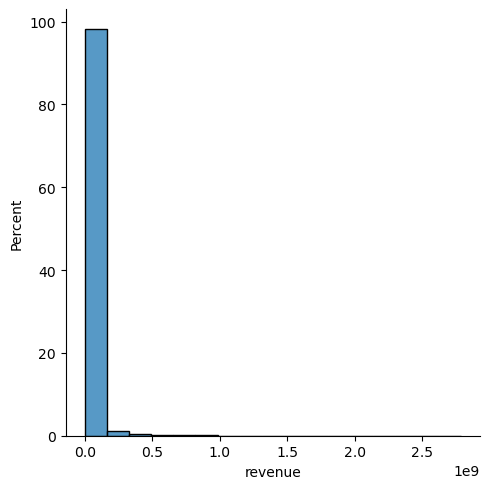

In [32]:
sns.displot(data.revenue, stat='percent')

In [33]:
data.describe()[['revenue']]

,revenue
count,4.546000e+04
mean,1.120935e+07
std,6.433225e+07
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.787965e+09


### Data cleaning
*By Tess Wagner*

Getting rid of movies that were not released. These were never shown to an audience, so these are not helpful.

In [34]:
data = data.drop(np.where(data['status'] != 'Released')[0])

In [35]:
data.adult.value_counts()

False    45006
True         8
Name: adult, dtype: int64

Getting rid of columns that will not help us predict revenue.
- Most are unique to each movie (aka the movie website or id number)
- Some columns (like vote_average) come out after the movies are released, so they are not helpful in predicting movie revenue before the films are released.

In [36]:
data = data.drop(['adult', 'homepage', 'id', 'imdb_id', 'original_title', 'poster_path', 'status', 'video', 'overview', 'production_companies', 'production_countries', 'spoken_languages', 'tagline', 'popularity', 'vote_average', 'vote_count'], axis=1)

Changing release date to a datetime object to make it useable.

In [37]:
data.release_date = pd.to_datetime(data.release_date)

Dropping the movies with no release date. We chose not to impute this variable because it is unlikely that there is a method to impute it even somewhat correctly based on the qualities of other movies in the dataset.

In [38]:
data.drop(data[data.release_date.isna()].index, inplace = True)

We also decided to drop the movies with missing values for runtime. We were not concerned about this affecting our predictions too much since those movies only made up 0.5% of the entire dataset.

In [39]:
data.drop(data[data.runtime.isna()].index, inplace = True)

### Data preparation
*By Tess Wagner*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we are predicting if a movie will produce revenue or not, we adapted the response variable and a few of the predictors into binary values to make it easier to determine the relationships between the predictors and the response.

2. Many of the predictors were categorical and contained thousands of possible values. Since the format of these predictors would make them difficult to use in a model, we turned them into dummy variables.

In the original dataset, `revenue` is a continuous variable. We are trying to predict whether a movie produced revenue or not, so we changed this to a binary variable.

In [40]:
data.loc[data['revenue']!=0, 'revenue'] = 1
data.loc[data['revenue']==0, 'revenue'] = 0

In the original dataset, `belongs_to_collection` contains the collection name that a movie belongs to. For all the movies that are not part of a collection, this column contains a missing value. To make this more useful, we are changing this column to contain binary information about whether a movie belongs to a collection or not.

In [41]:
data.loc[~data.belongs_to_collection.isnull(), 'belongs_to_collection'] = 1
data.loc[data.belongs_to_collection.isnull(), 'belongs_to_collection'] = 0

In the original dataset, there are multiple genres listed for each movie in the `genre` column. We decided to create dummy variables for each genre to better understand the relation between each individual genre and the response variable

In [42]:
def get_dummies_complex(column_name):
    column_name = column_name.apply(lambda x:eval(x))
    dict_items = []
    for list_of_dicts in column_name:
        for dictionary in list_of_dicts:
            if dictionary['name'] not in dict_items:
                dict_items.append(dictionary['name'])
    for item in dict_items:
        data[item] = 0
    for ind in data.index:
        items = column_name[ind]
        for dictionary in items:
            data.loc[ind, dictionary['name']] = 1
    return data

get_dummies_complex(data.genres)

# getting rid of the original genres column as we no longer need it
data.drop('genres', axis=1, inplace = True)

We are making the variable `original_language` into a binary response of movies that are in English vs not in English.

In [43]:
ind = data.loc[data.original_language.isin(['en']), 'original_language'].index
data['english'] = 0
for movie in ind:
    data.loc[ind, 'english'] = 1
    
# dropping original_language as we no longer need it
data.drop('original_language', axis = 1, inplace = True)

Because each release date is typically unique each movie, we figured it would be more useful to look at the release month and release year of each movie.

In [44]:
#| warning: false
data['release_year'] = data.release_date.dt.to_period("Y")
data['release_month'] = data.release_date.dt.month
data.drop('release_date', axis = 1, inplace = True)

Changing `budget` from an object type to an int type.

In [45]:
data.budget = data.budget.astype(int)

## Exploratory data analysis

### Distribution of response (as a binary variable)
*By Tess Wagner*

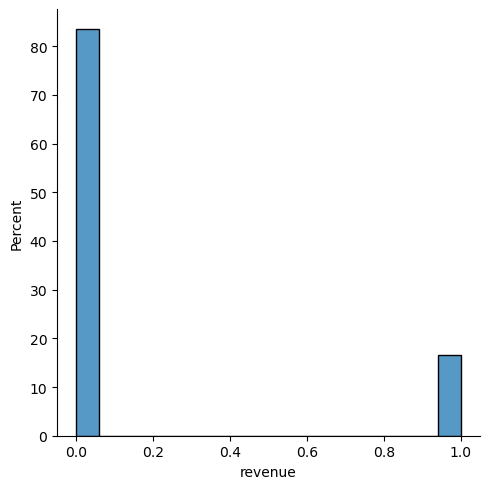

In [ ]:
sns.displot(data.revenue, stat='percent')

### Distribution of each predictor
*By Tess Wagner*

C:\Users\csky2\AppData\Local\Temp\ipykernel_6456\3522330777.py:30: FutureWarning: The behavior of .astype from period[A-DEC] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  sns.histplot(ax = axes[8,0], data = data.release_year.astype(int))


<Axes: xlabel='release_month', ylabel='Count'>

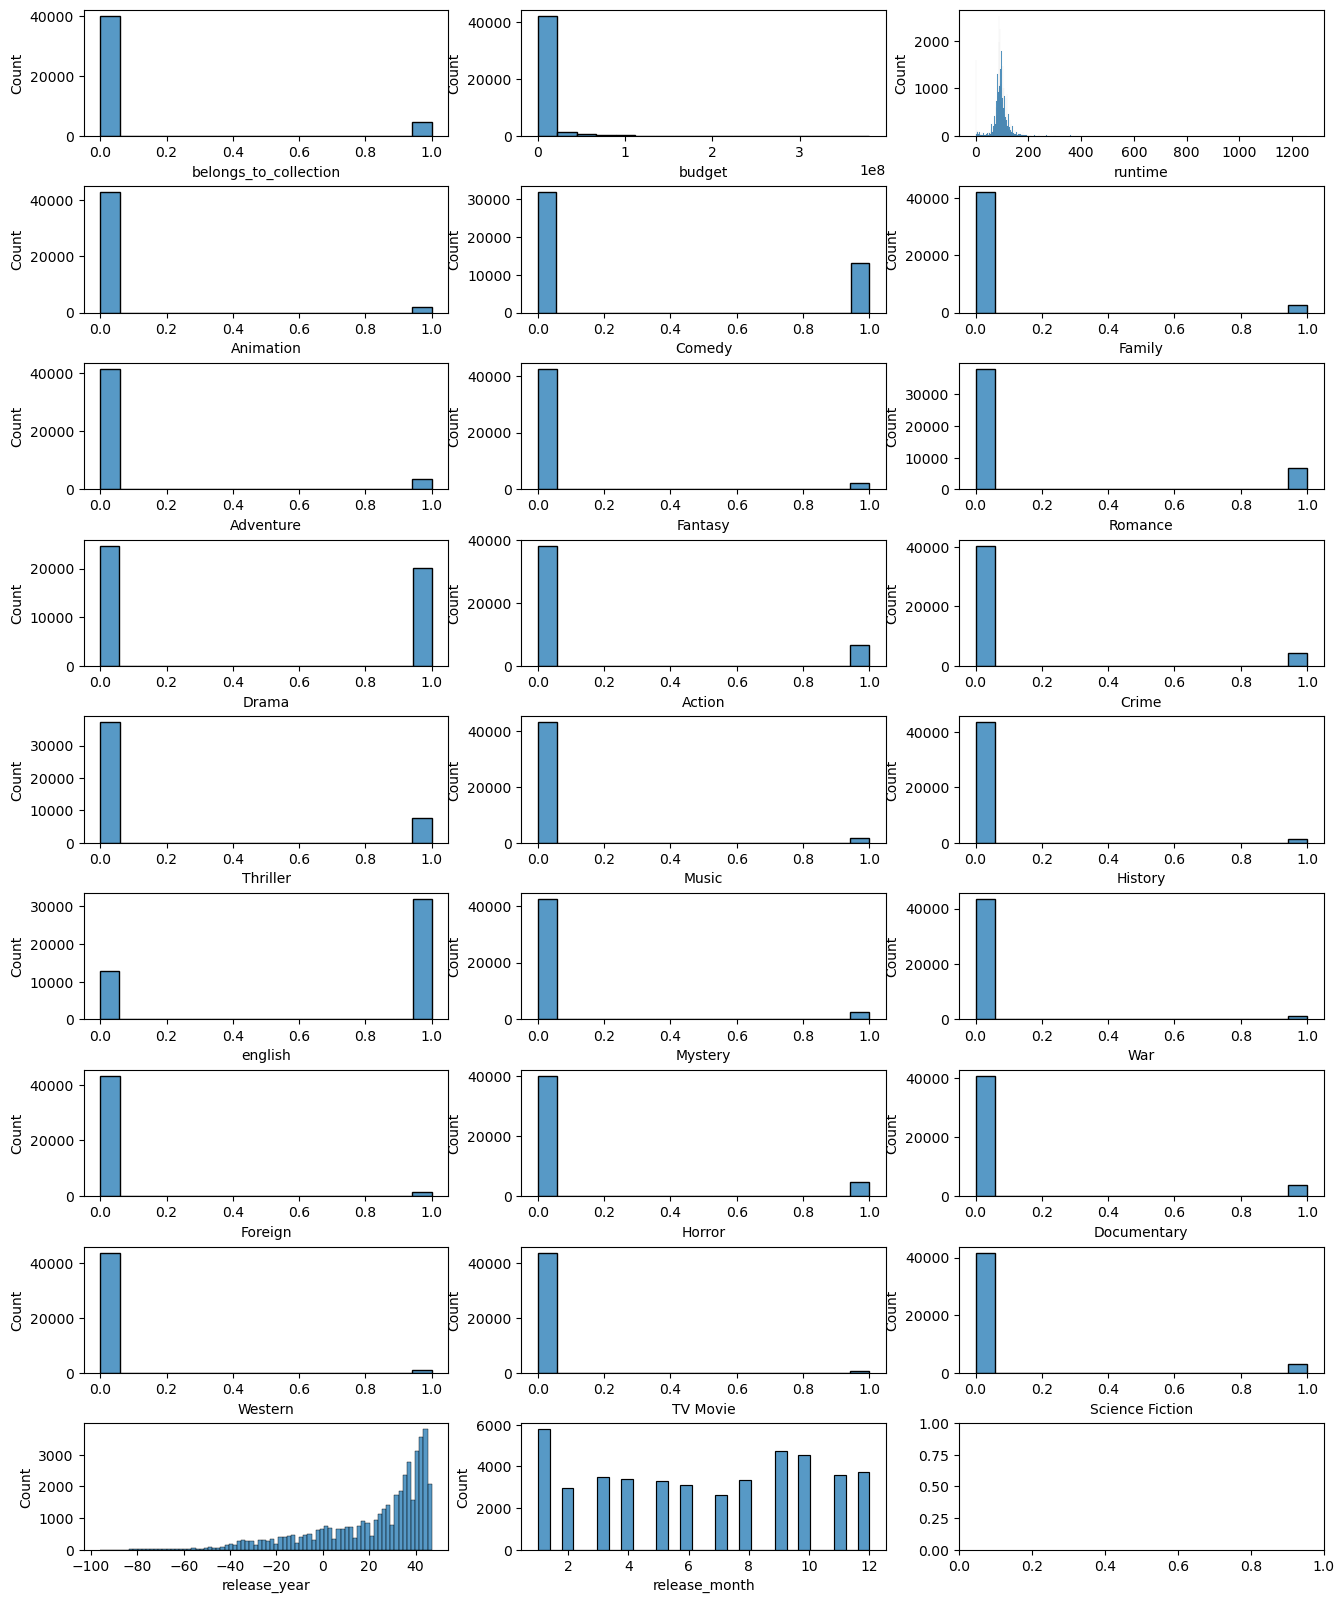

In [55]:
#| warning: false
fig, axes = plt.subplots(nrows = 9, ncols = 3, figsize = (16,20))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
plt.ylim(0,1)

sns.histplot(ax = axes[0,0], data = data.belongs_to_collection)
sns.histplot(ax = axes[0,1], data = data.budget)
sns.histplot(ax = axes[0,2], data = data.runtime)
sns.histplot(ax = axes[1,0], data = data.Animation)
sns.histplot(ax = axes[1,1], data = data.Comedy)
sns.histplot(ax = axes[1,2], data = data.Family)
sns.histplot(ax = axes[2,0], data = data.Adventure)
sns.histplot(ax = axes[2,1], data = data.Fantasy)
sns.histplot(ax = axes[2,2], data = data.Romance)
sns.histplot(ax = axes[3,0], data = data.Drama)
sns.histplot(ax = axes[3,1], data = data.Action)
sns.histplot(ax = axes[3,2], data = data.Crime)
sns.histplot(ax = axes[4,0], data = data.Thriller)
sns.histplot(ax = axes[4,1], data = data.Music)
sns.histplot(ax = axes[4,2], data = data.History)
sns.histplot(ax = axes[5,0], data = data.english)
sns.histplot(ax = axes[5,1], data = data.Mystery)
sns.histplot(ax = axes[5,2], data = data.War)
sns.histplot(ax = axes[6,0], data = data.Foreign)
sns.histplot(ax = axes[6,1], data = data.Horror)
sns.histplot(ax = axes[6,2], data = data.Documentary)
sns.histplot(ax = axes[7,0], data = data.Western)
sns.histplot(ax = axes[7,1], data = data['TV Movie'])
sns.histplot(ax = axes[7,2], data = data['Science Fiction'])
sns.histplot(ax = axes[8,0], data = data.release_year.astype(int))
sns.histplot(ax = axes[8,1], data = data.release_month)

### Response plotted against each predictor
*By Tess Wagner*

C:\Users\csky2\AppData\Local\Temp\ipykernel_6456\279856270.py:29: FutureWarning: The behavior of .astype from period[A-DEC] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  sns.scatterplot(ax = axes[8,0], x = data.release_year.astype(int), y = data.revenue)


<Axes: xlabel='release_month', ylabel='revenue'>

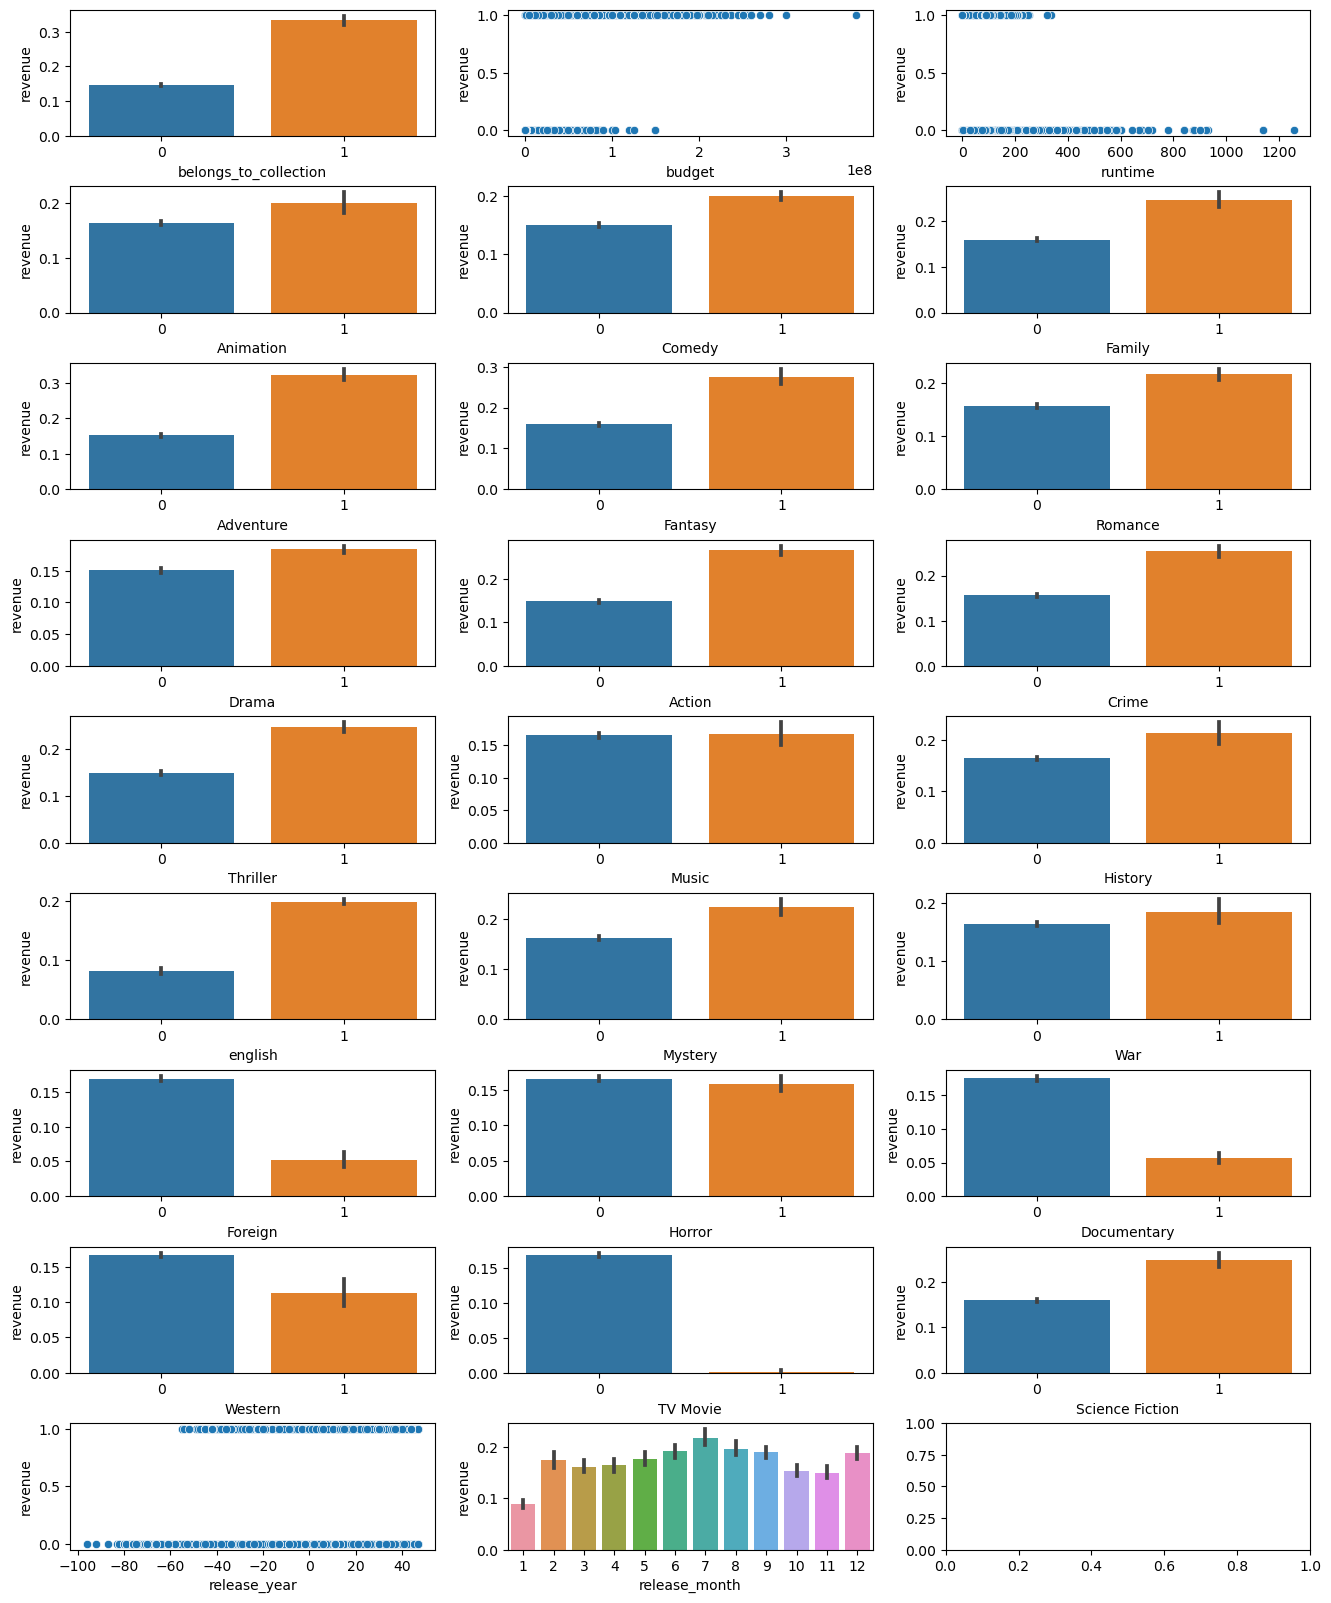

In [54]:
#| warning: false
fig, axes = plt.subplots(nrows = 9, ncols = 3, figsize = (16,20))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
plt.ylim(0,1)

sns.barplot(ax = axes[0,0], x = data.belongs_to_collection, y = data.revenue)
sns.scatterplot(ax = axes[0,1], x = data.budget, y = data.revenue)
sns.scatterplot(ax = axes[0,2], x = data.runtime, y = data.revenue)
sns.barplot(ax = axes[1,0], x = data.Animation, y = data.revenue)
sns.barplot(ax = axes[1,1], x = data.Comedy, y = data.revenue)
sns.barplot(ax = axes[1,2], x = data.Family, y = data.revenue)
sns.barplot(ax = axes[2,0], x = data.Adventure, y = data.revenue)
sns.barplot(ax = axes[2,1], x = data.Fantasy, y = data.revenue)
sns.barplot(ax = axes[2,2], x = data.Romance, y = data.revenue)
sns.barplot(ax = axes[3,0], x = data.Drama, y = data.revenue)
sns.barplot(ax = axes[3,1], x = data.Action, y = data.revenue)
sns.barplot(ax = axes[3,2], x = data.Crime, y = data.revenue)
sns.barplot(ax = axes[4,0], x = data.Thriller, y = data.revenue)
sns.barplot(ax = axes[4,1], x = data.Music, y = data.revenue)
sns.barplot(ax = axes[4,2], x = data.History, y = data.revenue)
sns.barplot(ax = axes[5,0], x = data.english, y = data.revenue)
sns.barplot(ax = axes[5,1], x = data.Mystery, y = data.revenue)
sns.barplot(ax = axes[5,2], x = data.War, y = data.revenue)
sns.barplot(ax = axes[6,0], x = data.Foreign, y = data.revenue)
sns.barplot(ax = axes[6,1], x = data.Horror, y = data.revenue)
sns.barplot(ax = axes[6,2], x = data.Documentary, y = data.revenue)
sns.barplot(ax = axes[7,0], x = data.Western, y = data.revenue)
sns.barplot(ax = axes[7,1], x = data['TV Movie'], y = data.revenue)
sns.barplot(ax = axes[7,2], x = data['Science Fiction'], y = data.revenue)
sns.scatterplot(ax = axes[8,0], x = data.release_year.astype(int), y = data.revenue)
sns.barplot(ax = axes[8,1], x = data.release_month, y = data.revenue)

In [49]:
data_predictors = data.drop(['revenue', 'title'], axis=1)
frequencies_updated = []
for col in data_predictors.columns:
    try:
        for num in range(0, 2):
            a = str(data_predictors[col].value_counts().index[num])
            b = str(data_predictors[col].value_counts()[num])
            holder = [a, b]
            frequencies_updated.append(holder)
    except:
        pass
frequencies_updated.append(['1.0', '5780'])
frequencies_updated.append(['9.0', '4765'])

In [51]:
blanks = []
for num in range(0,52):
    blanks.append(' ')
    
df_freq_upd = pd.DataFrame(frequencies_updated,index = [['belongs_to_collection']*2+['budget']*2+['runtime']*2+['Animation']*2+['Comedy']*2+['Family']*2+['Adventure']*2+['Fantasy']*2+['Romance']*2+['Drama']*2+['Action']*2+['Crime']*2+['Thriller']*2+['Horror']*2+['History']*2+['Science Fiction']*2+['Mystery']*2+['War']*2+['Foreign']*2+['Music']*2+['Documentary']*2+['Western']*2+['TV Movie']*2+['english']*2+['release_year']*2+['release_month']*2,
                                     blanks],
                    columns = ['Top Levels','Frequency'])
df_freq_upd

Top Levels Frequency
belongs_to_collection            0     40237
                                 1      4459
budget                           0     35845
                           5000000        25
runtime                       90.0      1478
                               0.0       106
Animation                        0     42785
                                 1      1911
Comedy                           0     31704
                                 1     12992
Family                           0     41966
                                 1      2730
Adventure                        0     41229
                                 1      3467
Fantasy                          0     42413
                                 1      2283
Romance                          0     38041
                                 1      6655
Drama                            0     24677
                                 1     20019
Action                           0     38160
                                 1      6536
Crime                            0     40420
                                 1      4276
Thriller                         0     37136
                                 1      7560
Horror                           0     40063
                                 1      4633
History                          0     43308
                                 1      1388
Science Fiction                  0     41690
                                 1      3006
Mystery                          0     42245
                                 1      2451
War                              0     43381
                                 1      1315
Foreign                          0     43109
                                 1      1587
Music                            0     43109
                                 1      1587
Documentary                      0     40843
                                 1      3853
Western                          0     43658
                                 1      1038
TV Movie                         0     43947
                                 1       749
english                          1     12808
                                 0     31888
release_year                  2014      1944
                              2013      1865
release_month                  1.0      5780
                               9.0      4765

## Developing the model: Hyperparameter tuning

In [57]:
#| echo: false
# separating predictors and response
y = data.revenue
X = data.drop(['revenue', 'title'], axis = 1)

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 45)

### RandomForestClassifier
*By Elijah Nacar*

In [59]:
data = pd.read_csv('movies_classification_updated.csv')
data.drop(['Unnamed: 0' , 'title'], axis=1, inplace=True)
data.head()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

X = data.drop('revenue', axis=1)
y = data.revenue

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an instance of the SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

In [77]:
params = {'n_estimators': [2000],
          'max_features': [0.5, 0.75, 1],
          'max_depth': [5, 10, 15],
          'min_samples_split': [2,5, 8, 10],
          'max_leaf_nodes': [20, 30, 40]
         }

param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
oob_recall = [0]*len(param_list)

i=0
for pr in param_list:
    model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                  max_features=pr[1], n_jobs=-1).fit(X_train_imputed,y_train)
    
    oob_pred = (model.oob_decision_function_[:,1]>=0.5).astype(int)     
    oob_recall[i] = precision_score(y_train, oob_pred)
    i=i+1
    

print("params= ", param_list[np.argmax(oob_recall)])

params=  (2000, 1, 15, 2, 45)


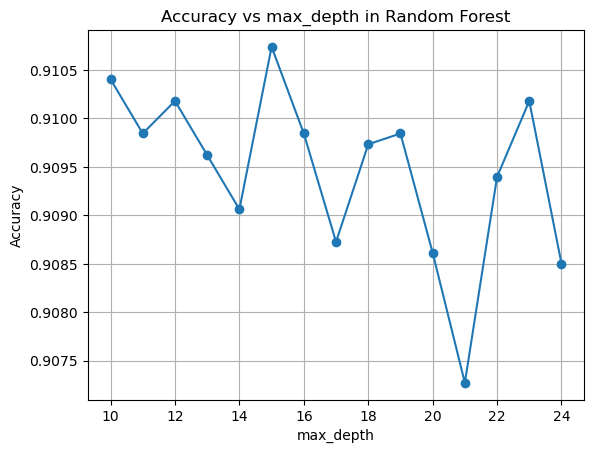

In [78]:
# Define the values of max_depth to explore
max_depth_values = range(10, 25)

# Train random forest models with different max_depth values
accuracies = []
for max_depth in max_depth_values:
    rf = RandomForestClassifier(random_state=1, max_depth=max_depth)
    rf.fit(X_train_imputed, y_train)
    accuracy = rf.score(X_test_imputed, y_test)
    accuracies.append(accuracy)

# Plot the max_depth values vs accuracies
plt.plot(max_depth_values, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_depth in Random Forest')
plt.grid(True)
plt.show()

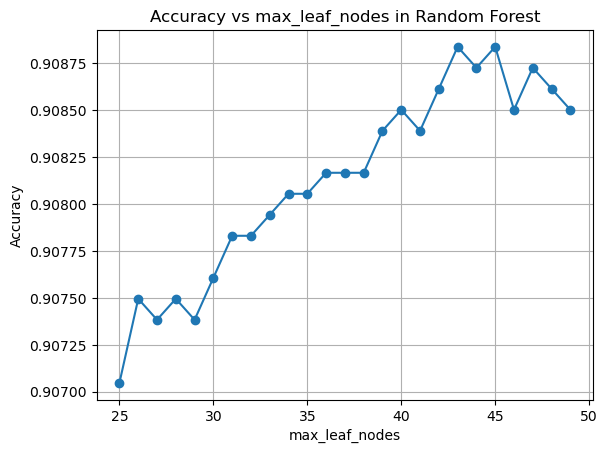

In [79]:
# Define the values of max_leaf_nodes to explore
max_leaf_nodes_values = range(25, 50)  

# Train random forest models with different max_leaf_nodes values
accuracies = []
for max_leaf_nodes in max_leaf_nodes_values:
    rf = RandomForestClassifier(random_state=1, max_leaf_nodes=max_leaf_nodes)
    rf.fit(X_train_imputed, y_train)
    accuracy = rf.score(X_test_imputed, y_test)
    accuracies.append(accuracy)

# Plot the max_leaf_nodes values vs accuracies
plt.plot(max_leaf_nodes_values, accuracies, marker='o')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_leaf_nodes in Random Forest')
plt.grid(True)
plt.show()

In [80]:
model = RandomForestClassifier(random_state=1, max_features=1, n_estimators = 2000, 
                               oob_score=True, max_depth = 15, max_leaf_nodes = 45, min_samples_split=2).fit(X_train_imputed, y_train)

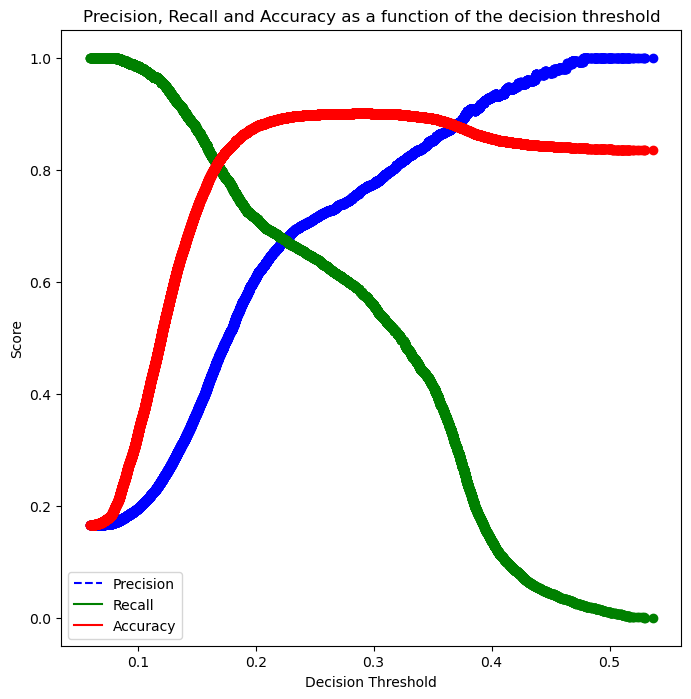

In [81]:
y_pred_prob = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_pred_prob)
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = y_pred_prob > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision, Recall and Accuracy as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  86.08501118568232
ROC-AUC:  0.89271320918774
Precision:  0.9154929577464789
Recall:  0.17567567567567569


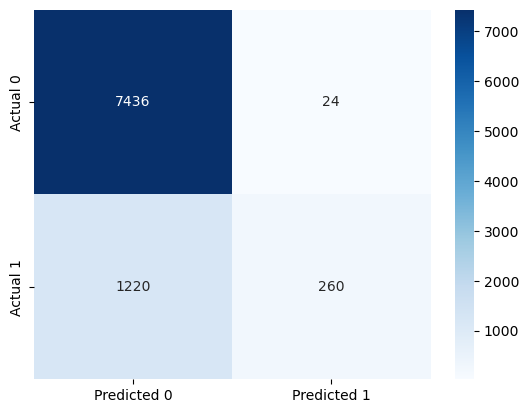

In [82]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.39

y_pred_prob = model.predict_proba(X_test_imputed)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### AdaBoost 
*Jack McNally*

In [83]:
#Tuning the hyperparameters of the AdaBoost model with a coarse search
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = range(1, 200, 50) 
grid['learning_rate'] = [0.01,0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=25), 
                          DecisionTreeClassifier(max_depth=100)]

# define the evaluation procedure
cv = KFold(n_splits=2, shuffle=True, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.806693 using {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 1}


C:\Users\csky2\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


>10 0.326 (0.007)
>20 0.320 (0.007)
>40 0.316 (0.006)
>50 0.318 (0.006)
>70 0.317 (0.007)


Text(0.5, 0, 'Number of trees')

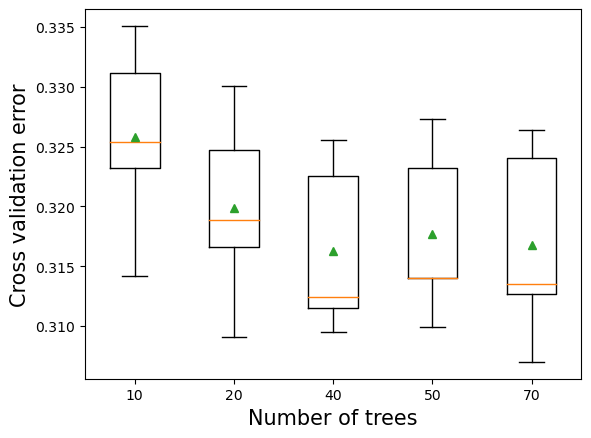

In [84]:
#Tuning only the number of trees in the model
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 20, 40, 50, 70]
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 0.317 (0.007)
>4 0.317 (0.009)
>7 0.345 (0.008)
>10 0.333 (0.005)
>13 0.323 (0.006)
>16 0.332 (0.007)
>19 0.342 (0.007)
>22 0.354 (0.007)
>25 0.364 (0.007)
>28 0.369 (0.005)
>31 0.368 (0.008)
>34 0.372 (0.008)
>37 0.370 (0.008)
>40 0.370 (0.005)
>43 0.369 (0.005)
>46 0.369 (0.006)
>49 0.369 (0.005)


Text(0.5, 0, 'Depth of each tree')

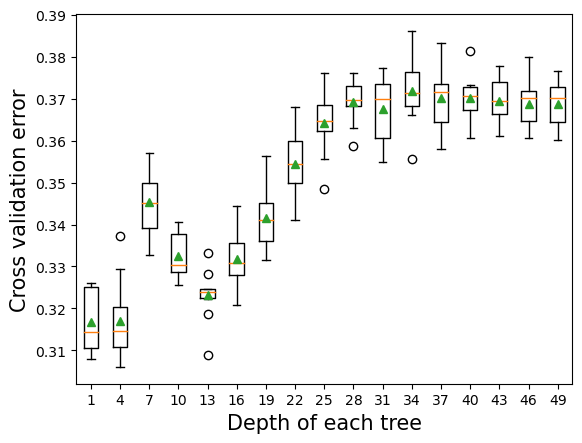

In [85]:
# Tuning only the depth of the model
def get_models():
    models = dict()
    n_depth = range(1, 50, 3)
    for n in n_depth:
        # define base model
        base = DecisionTreeClassifier(max_depth=n)
        # define ensemble model
        models[str(n)] = AdaBoostClassifier(base_estimator=base,n_estimators=50)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.001 0.3 (0.0)
>0.01 0.3 (0.0)
>0.1 0.3 (0.0)
>1.0 0.3 (0.0)
>1.1 0.3 (0.0)


Text(0.5, 0, 'Learning rate')

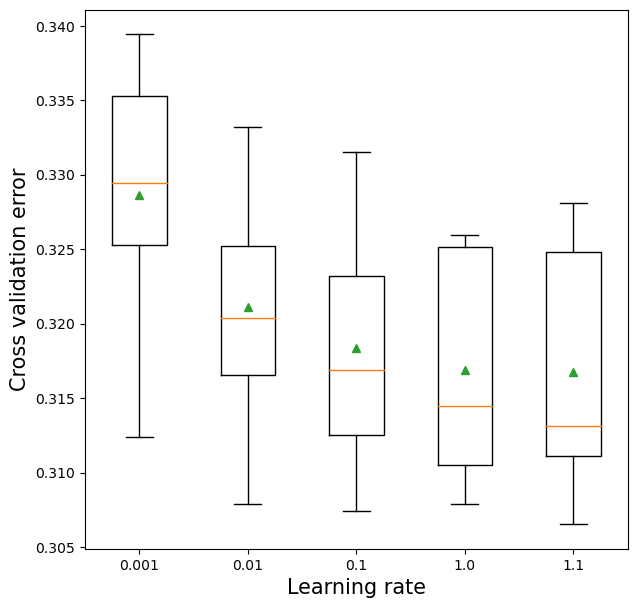

In [86]:
#Tuning only the learning rate of the model
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    n_rate = [0.001, 0.01, 0.1, 1.0, 1.1]
    for n in n_rate:
        models[n] = AdaBoostClassifier(learning_rate=n)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [87]:
#More specifically tuning the hyperparameters of the model
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [25, 50, 70]
grid['learning_rate'] = [0.001, 0.01, 0.1, 1]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4), 
                          DecisionTreeClassifier(max_depth=6)]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

C:\Users\csky2\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best: 0.798358 using {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.001, 'n_estimators': 25}


In [88]:
#Model with most optimal hyperparameters
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001).fit(X_train,y_train)


### Decision Tree
*By Tess Wagner*  

In [18]:
#| echo: false
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
import itertools as it

##### Base Decision Tree

In [89]:
# making base model to find the range of hyperparameters
model_base = DecisionTreeClassifier(random_state = 1)
model_base.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [90]:
# accuracy/recall/precision without tuning
cross_val_ypred = cross_val_predict(model_base, X_train, y_train, cv = 5, method = 'predict_proba')
y_pred = cross_val_ypred[:,1] > 0.5
y_pred = y_pred.astype(int)
print("Accuracy: ",accuracy_score(y_pred, y_train))
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

Accuracy:  0.8487526568967446
Precision:  0.5400992476388666
Recall:  0.57099339989846


##### Tuned Decision Tree

In [91]:
# finding range of hyperparameters
print("Maximum tree depth =", model_base.get_depth())
print("Maximum leaves =", model_base.get_n_leaves())

Maximum tree depth = 36
Maximum leaves = 4673


In [92]:
# coarse grid search
parameters = {'max_depth':range(2,34, 5),
              'max_leaf_nodes':range(2, 4737, 100), 
              'max_features': range(1, 26, 5)}

cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state=1)

grid_result = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring='precision')

grid_result.fit(X_train, y_train)

# best results in the grid search
print(grid_result.best_score_, grid_result.best_params_) 

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits
0.8379975167734987 {'max_depth': 2, 'max_features': 16, 'max_leaf_nodes': 102}


In [93]:
# finer grid search
parameters = {'max_depth':range(7,17, 2),
              'max_leaf_nodes':range(90, 300, 25), 
              'max_features': range(16, 29, 2)}

cv = KFold(n_splits = 5,shuffle=True,random_state=1)

grid_result = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring='precision')

grid_result.fit(X_train, y_train)

# best results in the grid search
print (grid_result.best_score_, grid_result.best_params_) 

Fitting 5 folds for each of 315 candidates, totalling 1575 fits
0.7762966689733239 {'max_depth': 9, 'max_features': 16, 'max_leaf_nodes': 90}


In [94]:
# training the model with the best results
model = DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, max_features=20, max_leaf_nodes=140,
                       random_state=1)

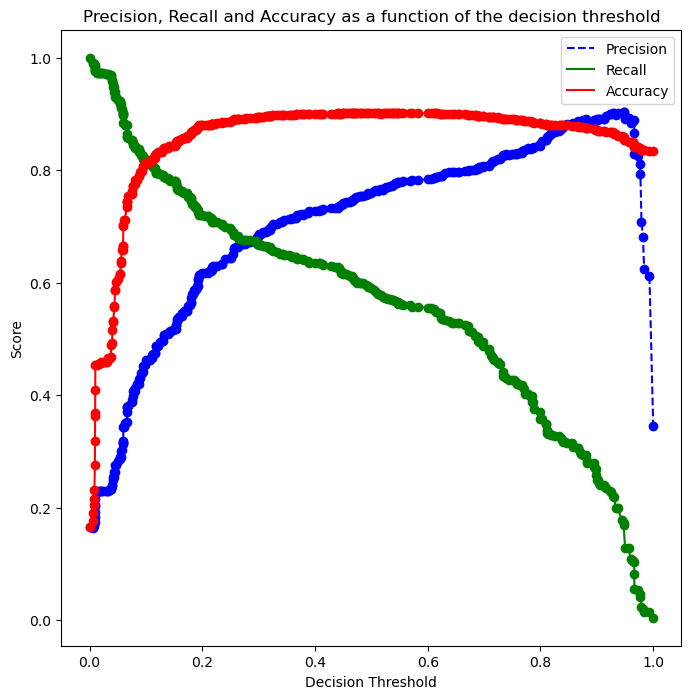

In [95]:
# finding the optimal decision threshold probability to maximize precision
cross_val_ypred = cross_val_predict(model, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
plot_precision_recall_vs_threshold(p, r, thresholds)

In [96]:
all_thresholds = pd.DataFrame({'thresholds': thresholds, 
                           'precision': p[:-1],
                           'recall': r[:-1],
                           'accuracy': acc})
all_thresholds.sort_values('precision', ascending=False).head(1)

,thresholds,precision,recall,accuracy
347,0.947368,0.90417,0.172449,0.8598


Accuracy:  0.8603031659022262
ROC-AUC:  0.9089531201557569
Precision:  0.9730848861283644
Recall:  0.1590793704518531


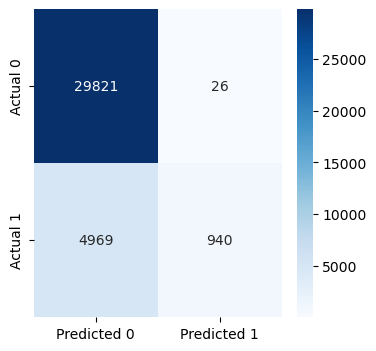

In [97]:
optimal_threshold = all_thresholds.sort_values('precision', ascending=False).loc[347, 'thresholds']

y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > optimal_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(ax=ax, data=cm, annot=True, cmap='Blues', fmt='g');

##### Decision Tree with optimal `ccp_alpha`

In [21]:
# Compute the pruning path during Minimal Cost-Complexity Pruning.
model = DecisionTreeClassifier(random_state = 1) 
path= model.cost_complexity_pruning_path(X_train,y_train)

In [22]:
alphas=path['ccp_alphas']

skf = StratifiedKFold(n_splits = 5,shuffle=True,random_state=1)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid = {'ccp_alpha':alphas}, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="precision", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for precision')
print(grid_search.best_params_)

Fitting 5 folds for each of 1420 candidates, totalling 7100 fits
Best params for precision
{'ccp_alpha': 0.0013034274896670112}


In [23]:
optimal_alpha = 0.0013034274896670112

# Model with the optimal value of 'ccp_alpha'
model_w_alpha = DecisionTreeClassifier(ccp_alpha=optimal_alpha,random_state=1)
model_w_alpha.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0013034274896670112, random_state=1)

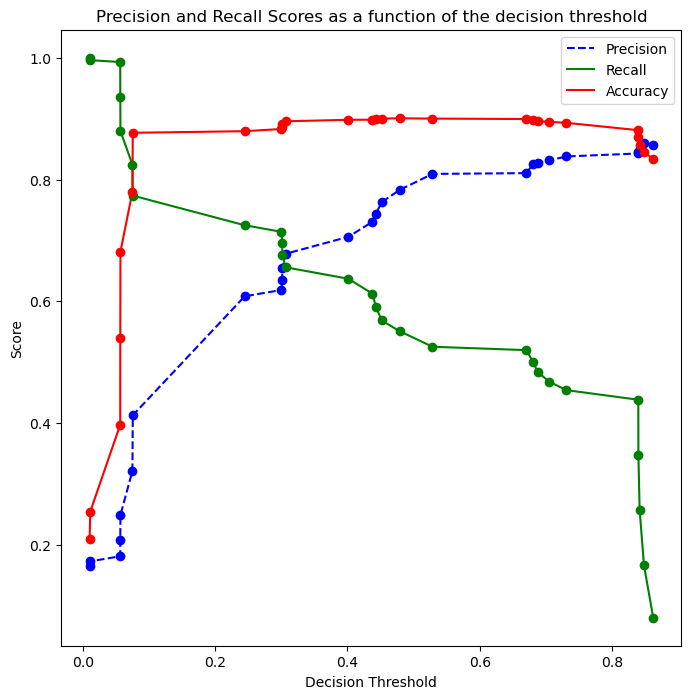

In [24]:
# finding decision threshold prob
cross_val_ypred = cross_val_predict(model_w_alpha, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
plot_precision_recall_vs_threshold(p, r, thresholds)

In [25]:
all_alpha_thresholds = pd.DataFrame({'thresholds': thresholds, 
                           'precision': p[:-1],
                           'recall': r[:-1],
                           'accuracy': acc})
all_alpha_thresholds.sort_values('precision', ascending=False).head()

,thresholds,precision,recall,accuracy
26,0.848161,0.860243,0.166807,0.845005
27,0.862155,0.856887,0.080626,0.833846
25,0.841608,0.848367,0.258037,0.857059
24,0.839734,0.844771,0.348090,0.869057
23,0.839608,0.842769,0.438478,0.881055


Accuracy:  0.833846067792818
ROC-AUC:  0.8337047488294183
Precision:  0.0
Recall:  0.0


C:\Users\csky2\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


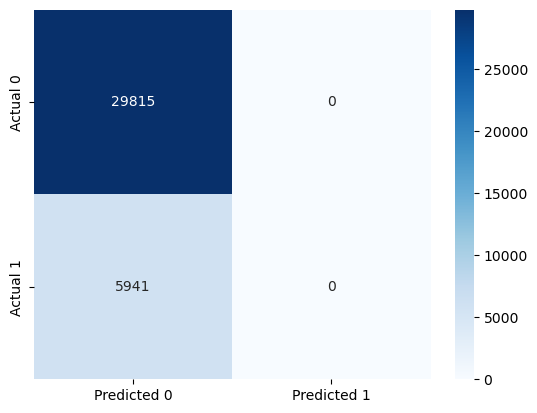

In [26]:
desired_threshold = 0.848161
y_pred_prob = model_w_alpha.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  0.8943394115672894
ROC-AUC:  0.8337047488294183
Precision:  0.8387096774193549
Recall:  0.45076586433260396


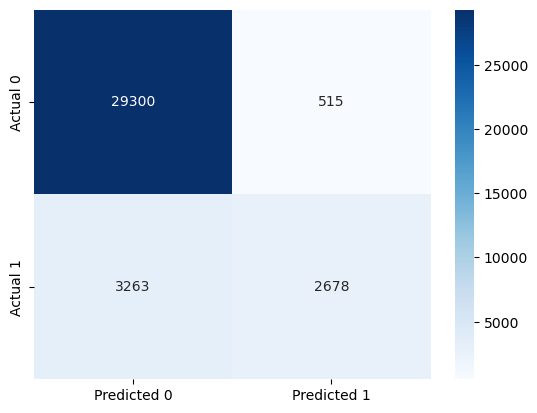

In [27]:
#choosing the choosing the threshold with the highest precision that didn't only predict zeros
desired_threshold = 0.730845

#choosing this threshold bc it has a very high accuracy and precision both around 88%

y_pred_prob = model_w_alpha.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

##### Decision Tree with simultaneously tuned `ccp_alpha` and hyperparameters

In [28]:
parameters = {'max_depth':range(2,34, 5),
              'max_leaf_nodes':range(2, 4737, 100), 
              'max_features': range(1, 26, 5),
              'ccp_alpha':alphas}

cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state=1)

grid_result = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring="precision")

grid_result.fit(X_train, y_train)
print (grid_result.best_score_, grid_result.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.776594970241135 {'max_leaf_nodes': 2002, 'max_features': 1, 'max_depth': 7, 'ccp_alpha': 3.485160102231362e-05}


In [29]:
model_combined = DecisionTreeClassifier(ccp_alpha=3.485160102231362e-05,random_state=1, max_leaf_nodes=2002, max_features=1, max_depth=7)
model_combined.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=3.485160102231362e-05, max_depth=7,
                       max_features=1, max_leaf_nodes=2002, random_state=1)

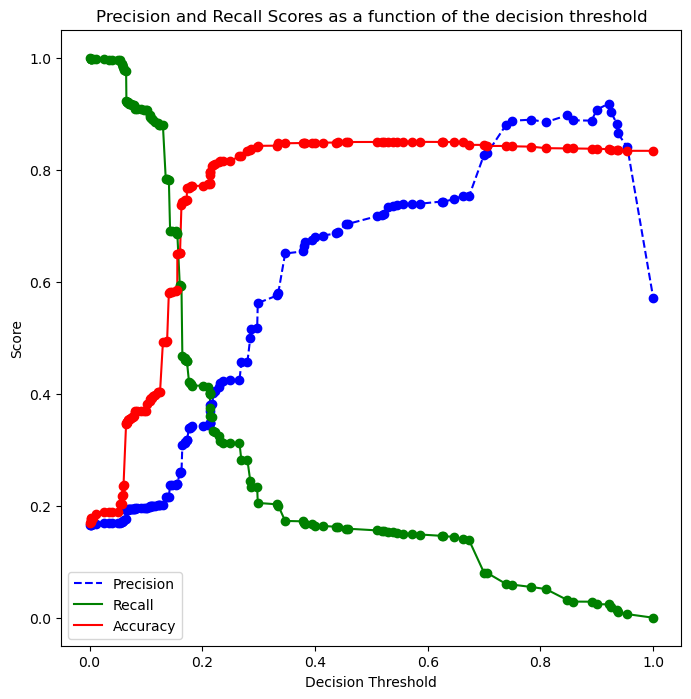

In [30]:
# finding decision threshold prob
cross_val_ypred = cross_val_predict(model_combined, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
plot_precision_recall_vs_threshold(p, r, thresholds)

In [31]:
all_alpha_thresholds = pd.DataFrame({'thresholds': thresholds, 
                           'precision': p[:-1],
                           'recall': r[:-1],
                           'accuracy': acc})
all_alpha_thresholds.sort_values('precision', ascending=False).head(1)

,thresholds,precision,recall,accuracy
125,0.92126,0.918239,0.024575,0.836867


Accuracy:  0.8380971025841817
ROC-AUC:  0.6966719530579968
Precision:  0.9418604651162791
Recall:  0.02726813667732705


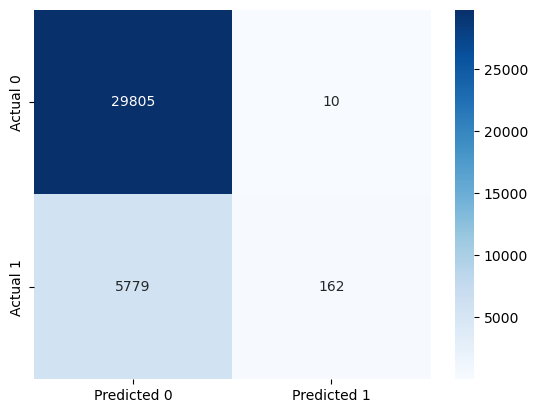

In [32]:
#Performance metrics computation for the optimum decision threshold probability - training data
desired_threshold = 0.92126
y_pred_prob = model_combined.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### XGBoost & Lasso
*By Samuel Sword*

**See the file "XGBoost+Lasso.ipynb" to view the code for the hyperparameter tuning**

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

*Hard Voting Ensemble (Sam Sword):*

In [98]:
#| echo: false
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [101]:
# Code taken from https://pypi.org/project/gdown/
import gdown

In [ ]:
url = "https://drive.google.com/drive/folders/15LpkCSgro5H-ZzbARRVw7cT23sz3cPGC?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/project/ModelEnsemle.ipynb',
 '/content/project/movies_classification_updated.csv',
 '/content/project/movies_classification.csv',
 '/content/project/movies_metadata.csv',
 '/content/project/XGBoost_model.ipynb']

In [ ]:
#| warning: false
data = pd.read_csv('/content/project/movies_classification_updated.csv')
metadata = pd.read_csv('/content/project/movies_metadata.csv')

<ipython-input-4-238be40e0e7d>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/project/movies_metadata.csv')


In [ ]:
#dropping data with null values since theres so few:

#null runtimes
null_runtimes = data[data['runtime'].isnull()].index.tolist()
data = data.drop(null_runtimes)

#null release info
null_dates = data[data['release_year'].isnull()].index.tolist()
data = data.drop(null_dates)

In [ ]:
y=data.revenue
X= data.drop(columns=['Unnamed: 0', 'revenue', 'popularity', 'title'])

In [ ]:
#splitting into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
X_test=X_test.drop(columns=['vote_average', 'vote_count'])
X_train=X_train.drop(columns=['vote_average', 'vote_count'])

In [ ]:
#ensembling
#Tuned AdaBoost model from Section 7.2.4
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001).fit(X_train,y_train)
y_pred= model_ada.predict(X_test)
test_precision_ada = precision_score(y_test, y_pred)


# Tuned XGBoost model from Section 9.2.6
model_xgb = xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
test_precision_xgb = precision_score(y_test, y_pred)


# Tuned Decision tree classifier
model_dt = DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140).fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
test_precision_dt = precision_score(y_test, y_pred)

#random forest
model_rf = RandomForestClassifier(n_estimators=2000, max_features=1, min_samples_split=2, max_depth=15, max_leaf_nodes=45, random_state=1).fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
test_precision_rf = precision_score(y_test, y_pred)

#lasso
model_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1).fit(X_train, y_train)
y_pred = model_lasso.predict(X_test)
test_precision_lasso = precision_score(y_test, y_pred)


print("Adaboost model precision = ",test_precision_ada)
print("XGBoost model precision = ",test_precision_xgb)
print("Decision Tree Classifier model precision = ",test_precision_dt)
print("Random Forest Classifier model precision = ",test_precision_rf)
print("Lasso Classifier model precision = ",test_precision_lasso)


Adaboost model precision =  0.7895716945996276
XGBoost model precision =  0.7849740932642487
Decision Tree Classifier model precision =  0.7814685314685315
Random Forest Classifier model precision =  1.0
Lasso Classifier model precision =  0.8698060941828255


### MANUAL ENSEMBLING

### Adaboost

In [ ]:
cross_val_ypred = cross_val_predict(AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
#| warning: false
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Text(0.5, 1.0, 'Train data performance metrics')

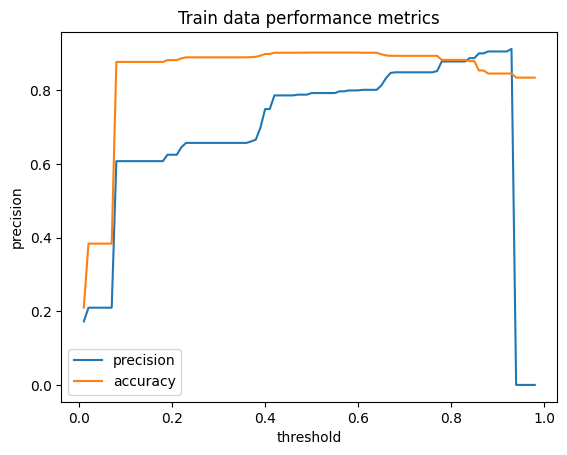

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.7,.9,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

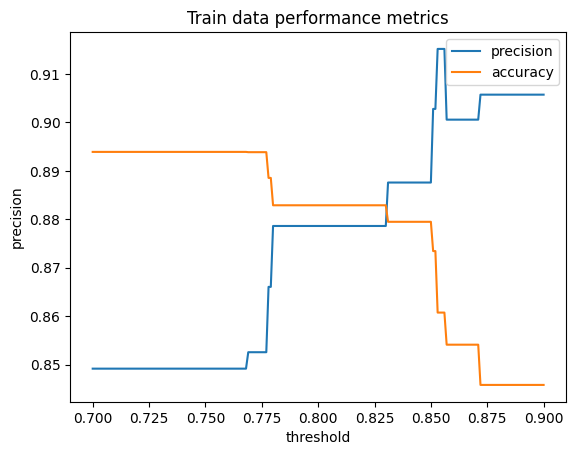

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [ ]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.87].sort_values('precision', ascending=False)

,accuracy,precision,threshold
152,0.873448,0.902794,0.852
151,0.873448,0.902794,0.851
141,0.879489,0.887597,0.841
131,0.879489,0.887597,0.831
132,0.879489,0.887597,0.832
...,...,...,...
41,0.89392,0.849175,0.741
40,0.89392,0.849175,0.74
39,0.89392,0.849175,0.739
37,0.89392,0.849175,0.737


In [ ]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001).fit(X_train, y_train)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.852

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_ADA = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred_ADA, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred_ADA))

Test data performance metrics (with decision threshold of 0.849):
Accuracy:  86.26398210290827
Precision:  0.9468085106382979


### XGBoost

In [ ]:
cross_val_ypred = cross_val_predict(xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

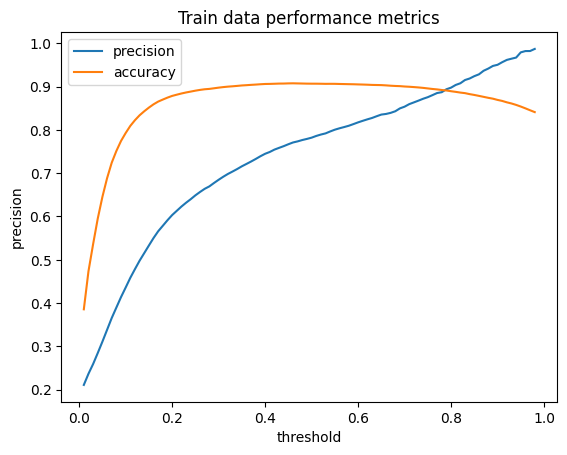

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.6,.85,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

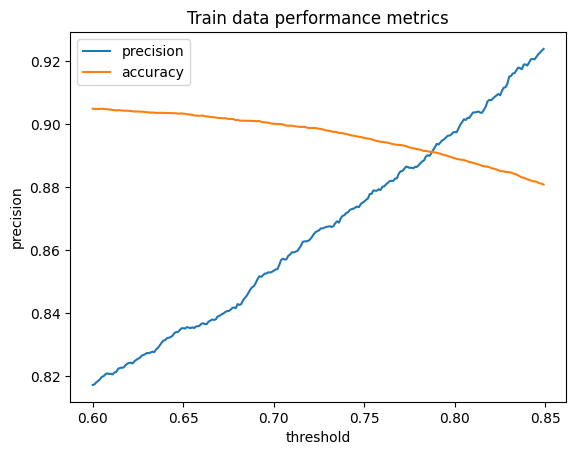

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [ ]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.88].sort_values('precision', ascending=False)

,accuracy,precision,threshold
249,0.880775,0.92379,0.849
248,0.881027,0.923274,0.848
247,0.881167,0.922607,0.847
246,0.881391,0.922065,0.846
245,0.881698,0.921224,0.845
...,...,...,...
4,0.904743,0.819016,0.604
3,0.904743,0.818529,0.603
2,0.904771,0.818089,0.602
1,0.904771,0.817444,0.601


In [ ]:
model = xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)

In [ ]:
pd.concat([pd.Series(X_test.columns, name = 'predictor'), 
           pd.Series(model.feature_importances_, 
                     name = 'importance')], axis = 1).sort_values(by = 'importance', ascending=False)

,predictor,importance
1,budget,0.498358
23,english,0.054206
0,belongs_to_collection,0.044424
4,Comedy,0.035602
24,release_year,0.032953
22,TV Movie,0.029939
2,runtime,0.026942
9,Drama,0.025464
8,Romance,0.022840
3,Animation,0.021011


In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.849

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_XGB = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred_XGB, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred_XGB))

Test data performance metrics (with decision threshold of 0.849):
Accuracy:  88.27740492170022
Precision:  0.9251968503937008


### Decision Tree

In [ ]:
cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

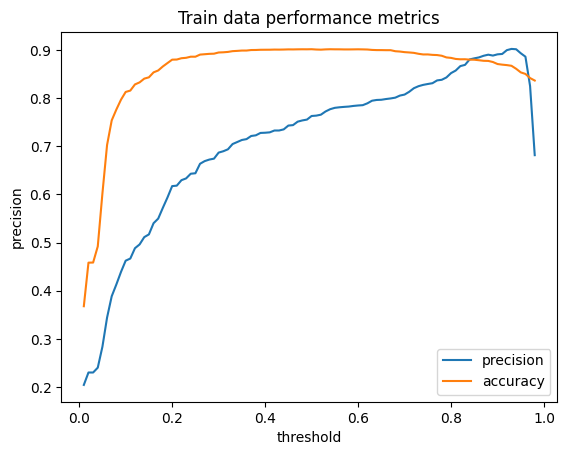

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.7,.85,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

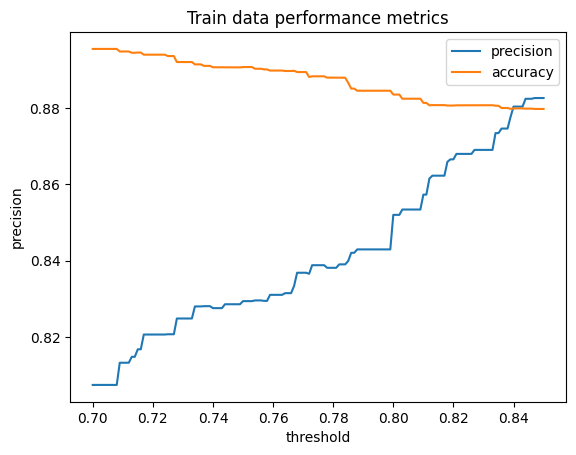

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [ ]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.87].sort_values('precision', ascending=False)

,accuracy,precision,threshold
150,0.879796,0.88266,0.85
149,0.879796,0.88266,0.849
148,0.879796,0.88266,0.848
147,0.879796,0.88266,0.847
146,0.87988,0.882464,0.846
...,...,...,...
5,0.895542,0.80741,0.705
4,0.895542,0.80741,0.704
3,0.895542,0.80741,0.703
2,0.895542,0.80741,0.702


In [ ]:
model = DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140).fit(X_train, y_train)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.85

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_DT = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred_DT, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred_DT))

Test data performance metrics (with decision threshold of 0.849):
Accuracy:  88.51230425055928
Precision:  0.8939130434782608


### Random Forest

In [ ]:
cross_val_ypred = cross_val_predict(RandomForestClassifier(n_estimators=2000, max_features=1, min_samples_split=2, max_depth=15, max_leaf_nodes=45, random_state=1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
#| warning: false
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Text(0.5, 1.0, 'Train data performance metrics')

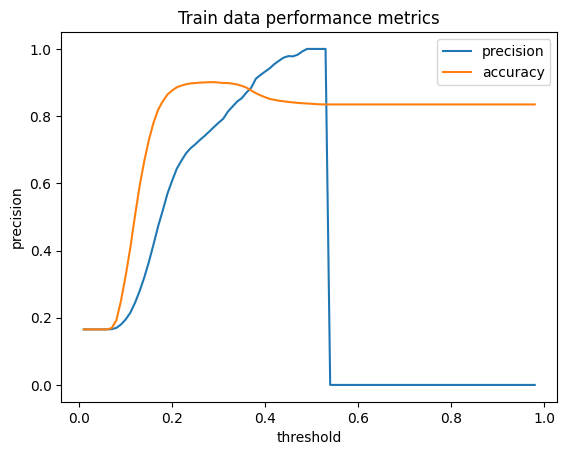

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
# optimal threshold around 0.5
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.2,.4,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

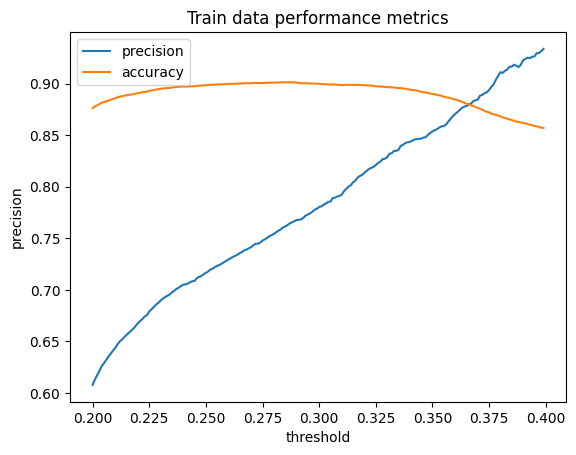

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')
#about .785

In [ ]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.86].sort_values('precision', ascending=False)

,accuracy,precision,threshold
192,0.860835,0.925251,0.392
193,0.860275,0.924651,0.393
191,0.861534,0.923894,0.391
190,0.861925,0.922609,0.39
186,0.863995,0.9184,0.386
...,...,...,...
4,0.881446,0.625867,0.204
3,0.88016,0.62123,0.203
2,0.879013,0.617103,0.202
1,0.877811,0.61287,0.201


In [ ]:
model = RandomForestClassifier(n_estimators=2000, max_features=1, min_samples_split=2, max_depth=15, max_leaf_nodes=45, random_state=1).fit(X_train, y_train)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.392

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_RF = y_pred.astype(int)

print('Test data performance metrics (with decision threshold of 0.849):')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred_RF, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred_RF))

Test data performance metrics (with decision threshold of 0.849):
Accuracy:  86.01789709172259
Precision:  0.9197080291970803


### Lasso

In [ ]:
cross_val_ypred = cross_val_predict(LogisticRegression(penalty='l1', solver='liblinear', C=0.1), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.01,.99,0.01)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

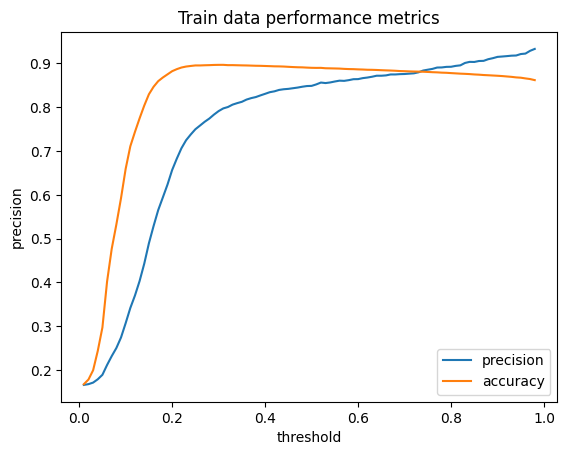

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
performance_iter = pd.DataFrame(columns = ('accuracy', 'precision', 'threshold'))
iter_number = 0
threshold_hyperparam_vals = np.arange(0.6,.80,0.001)

In [ ]:
for threshold_prob in threshold_hyperparam_vals:
            predicted_class = cross_val_ypred[:,1] > threshold_prob
            predicted_class = predicted_class.astype(int)

            #Computing the accuracy
            accuracy = accuracy_score(predicted_class, y_train)
            performance_iter.loc[iter_number, 'threshold'] = threshold_prob
            performance_iter.loc[iter_number, 'accuracy'] = accuracy
            performance_iter.loc[iter_number, 'precision'] = precision_score(y_train, predicted_class)

            iter_number = iter_number + 1 

Text(0.5, 1.0, 'Train data performance metrics')

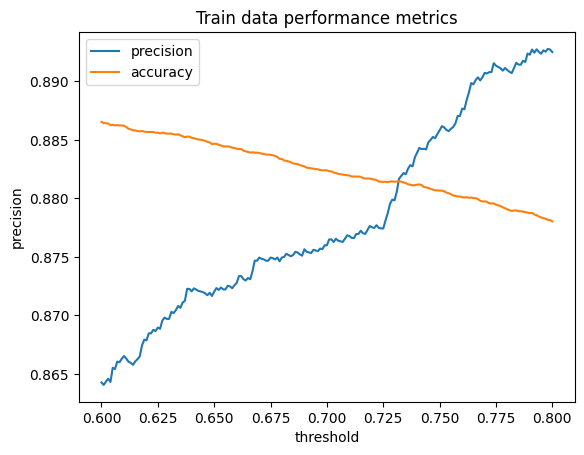

In [ ]:
sns.lineplot(x=performance_iter.threshold, y=performance_iter.precision, label='precision')
sns.lineplot(x=performance_iter.threshold, y=performance_iter.accuracy, label = 'accuracy')
plt.title('Train data performance metrics')

In [ ]:
#finding the decision thresholds that meet the requirements using the underlying data (seems to be many options in this case)
#performance_iter.loc[performance_iter['accuracy']>.70].sort_values('recall',ascending=False)
performance_iter[performance_iter['accuracy']>.88].sort_values('precision', ascending=False)

,accuracy,precision,threshold
166,0.88002,0.89012,0.766
164,0.880076,0.889851,0.764
165,0.88002,0.889745,0.765
163,0.880048,0.889049,0.763
162,0.880104,0.88841,0.762
...,...,...,...
3,0.886397,0.864587,0.603
2,0.886425,0.864353,0.602
4,0.886257,0.86432,0.604
0,0.886537,0.86428,0.6


In [ ]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1).fit(X_train, y_train)

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.8
y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred_lasso = y_pred.astype(int)

print('Test data performance metrics:')
#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  
#Computing the recall
print("Precision: ", precision_score(y_test, y_pred))

Test data performance metrics:
Accuracy:  87.90827740492169
Precision:  0.8997995991983968


In [ ]:
predictions = pd.DataFrame({'Decision Tree': y_pred_DT, 'XGBoost': y_pred_XGB, 'ADABoost': y_pred_ADA, 'Random Forest':y_pred_RF, 'Lasso': y_pred_lasso})
predictions['majority'] = predictions['Decision Tree'] + predictions.XGBoost + predictions.ADABoost + predictions['Random Forest'] + predictions['Lasso']

In [ ]:
majority_predictions = []
for x in predictions.majority:
    if x > 2:
        majority_predictions.append(1)
    if x <= 2:
        majority_predictions.append(0)

In [ ]:
len(majority_predictions)

8940

In [ ]:
print('Test data performance metrics of ensemble:')
print('Accuracy:', accuracy_score(y_test, majority_predictions))
print('Precision:', precision_score(y_test, majority_predictions))

Test data performance metrics of ensemble:
Accuracy:  87.88590604026845
Precision:  0.93058568329718


### Stacking ensemble - Logistic Regression
*By Tess Wagner*

In [60]:
#ensembling
#Tuned AdaBoost model from Section 7.2.4
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), random_state=1,n_estimators=25,learning_rate = 0.001).fit(X_train,y_train)

# Tuned XGBoost model from Section 9.2.6
model_xgb = xgb.XGBClassifier(gamma= 0, learning_rate=0.25, max_depth=6, n_estimators= 150, reg_lambda=100, scale_pos_weight=1).fit(X_train, y_train)

# Tuned Decision tree classifier
model_dt = DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140).fit(X_train, y_train)

#random forest
model_rf = RandomForestClassifier(n_estimators=2000, max_features=1, min_samples_split=2, max_depth=15, max_leaf_nodes=45, random_state=1).fit(X_train, y_train)

#lasso
model_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1).fit(X_train, y_train)


In [70]:
hyperparam_vals = 10**np.linspace(-3.5, 1)
threshold_hyperparam_vals = np.arange(0.1, 0.9,0.01)
cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state=1)

scores = {}

for C in hyperparam_vals:
    lrse_c_model = StackingClassifier(estimators=[('model_ada',model_ada),('model_xgb',model_xgb),('model_dt',model_dt), ('model_rf',model_rf), ('model_lasso',model_lasso)],
                                   final_estimator=LogisticRegression(random_state=1, max_iter=10000, C=C),
                                   n_jobs=-1,
                                   cv = cv)
    lrse_c_model.fit(X_train, y_train)
    
    predicted_probability = cross_val_predict(lrse_c_model, X_train, y_train, cv = cv, n_jobs=-1, method = 'predict_proba')
    
    for threshold_prob in threshold_hyperparam_vals:
        predicted_class = predicted_probability[:,1] > threshold_prob
        predicted_class = predicted_class.astype(int)
    
        scores[C] = precision_score(predicted_class, y_train)
        
print("Best value of max_features= ", np.argmax(list(scores.values()))+1)

Best value of max_features= 1


In [62]:
lrse_model = StackingClassifier(estimators=[('model_ada',model_ada),('model_xgb',model_xgb),('model_dt',model_dt), ('model_rf',model_rf), ('model_lasso',model_lasso)],
                                   final_estimator=LogisticRegression(random_state=1, max_iter=1000, C=1),
                                   n_jobs=-1,
                                   cv = cv)
lrse_model.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimators=[('model_ada',
                                AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                   learning_rate=0.001,
                                                   n_estimators=25,
                                                   random_state=1)),
                               ('model_xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_byt...
                                DecisionTreeClassifier(max_depth=9,
                                                       max_features=20,
                                                       max_leaf_nodes=140,
                                                       random_state=1)),
                               ('model_rf',
                                RandomForestClassifier(max_depth=15,
                                                       max_features=1,
                                                       max_leaf_nodes=45,
                                                       n_estimators=2000,
                                                       random_state=1)),
                               ('model_lasso',
                                LogisticRegression(C=0.1, penalty='l1',
                                                   solver='liblinear'))],
                   final_estimator=LogisticRegression(C=1, max_iter=1000,
                                                      random_state=1),
                   n_jobs=-1)

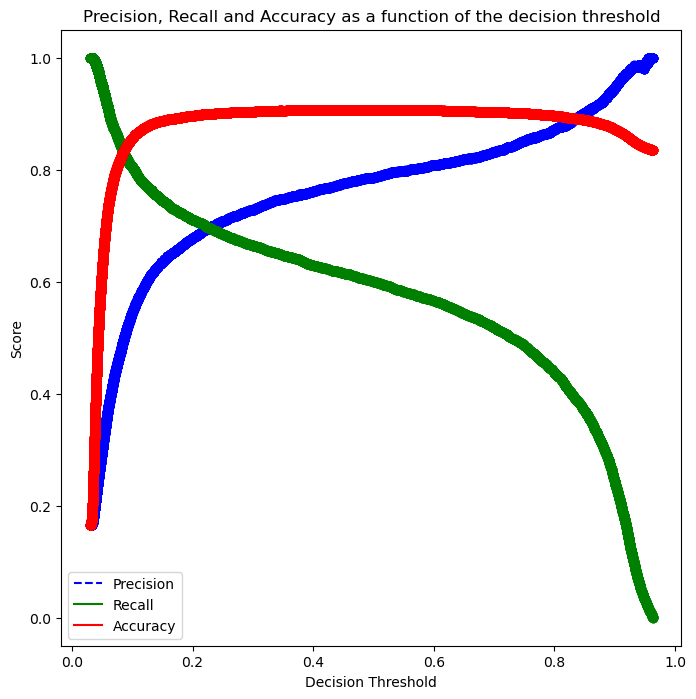

In [71]:
# plotting accuracy and recall
predicted_probability = cross_val_predict(lrse_model, X_train, y_train, cv = cv, n_jobs=-1, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, predicted_probability[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = predicted_probability[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
plot_precision_recall_vs_threshold(p, r, thresholds)

In [72]:
all_thresholds = pd.DataFrame({'thresholds': thresholds, 
                           'precision': p[:-1],
                           'recall': r[:-1],
                           'accuracy': acc})
all_thresholds.sort_values('precision', ascending=False).head(2)

,thresholds,precision,recall,accuracy
35649,0.963681,1.0,0.000169,0.834741
35581,0.958093,1.0,0.011677,0.836643


Test Accuracy:  0.8370246085011186
Test ROC-AUC:  0.9100825121368017
Test Precision:  1.0
Test Recall:  0.015540540540540541


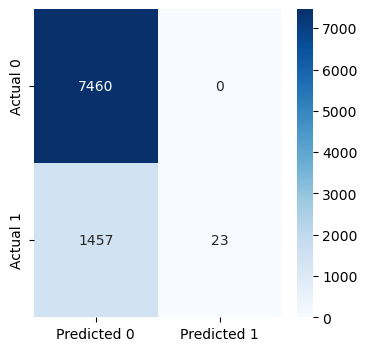

In [73]:
lrse_threshold = 0.958021
y_pred_prob = lrse_model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > lrse_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("Test ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred))
print("Test Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(ax=ax, data=cm, annot=True, cmap='Blues', fmt='g');